In [1]:
%%capture
import os
import tensorflow as tf
from tensorflow import keras
import pathlib
import zipfile
import math as m
import tarfile
!pip install Pillow
import pandas as pd
from sklearn.utils import shuffle
from PIL import Image
import random
from numpy import array
from tensorflow.keras import backend as K
import numpy as np
import zipfile
from tqdm import tqdm_notebook
import csv
!pip install h5py
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
import IPython.display as display
import heatmap
import object_detection

In [2]:
train_path = "/home/pk2573/GTSRB_Final_Training_Images.zip"
test_path = "/home/pk2573/GTSRB_Final_Test_Images.zip"

In [3]:
def un_zip(file_path):
    path, fname = os.path.split(file_path)
    
    if (fname.endswith("tgz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path)
        tar.close()
    elif (fname.endswith("tar")):
        tar = tarfile.open(fname, "r:")
        tar.extractall(path)
        tar.close()
    elif (fname.endswith("zip")):
        zip_ref = zipfile.ZipFile(fname, 'r')
        zip_ref.extractall(path)
        zip_ref.close()
    
    if fname.split("_")[2] == "Training":
        new_path = path + "/" + fname.split("_")[0] + "/Final_Training/Images"
    elif fname.split("_")[2] == "Test":
        new_path = path + "/" + fname.split("_")[0] + "/Final_Test"
    
    return new_path

In [4]:
os.chdir(str(Path.home()))

In [5]:
train_path = un_zip(train_path)
train_p = pathlib.Path(train_path)

In [6]:
os.chdir(str(Path.home()))

In [7]:
test_path = un_zip(test_path)
test_p = pathlib.Path(test_path)

In [8]:
os.chdir(str(Path.home()))
print("All training folders found:")
for item in train_p.iterdir():
    print(item)
all_train_image_paths = list(train_p.glob('*/*'))
all_train_image_paths = [str(path) for path in all_train_image_paths]
random.shuffle(all_train_image_paths)
print("\nWe have " + str(len(all_train_image_paths)) + " training images")

All training folders found:
/home/pk2573/GTSRB/Final_Training/Images/00001
/home/pk2573/GTSRB/Final_Training/Images/00015
/home/pk2573/GTSRB/Final_Training/Images/00031
/home/pk2573/GTSRB/Final_Training/Images/00016
/home/pk2573/GTSRB/Final_Training/Images/00022
/home/pk2573/GTSRB/Final_Training/Images/00038
/home/pk2573/GTSRB/Final_Training/Images/00026
/home/pk2573/GTSRB/Final_Training/Images/00037
/home/pk2573/GTSRB/Final_Training/Images/00006
/home/pk2573/GTSRB/Final_Training/Images/00013
/home/pk2573/GTSRB/Final_Training/Images/00030
/home/pk2573/GTSRB/Final_Training/Images/00036
/home/pk2573/GTSRB/Final_Training/Images/00008
/home/pk2573/GTSRB/Final_Training/Images/00035
/home/pk2573/GTSRB/Final_Training/Images/00023
/home/pk2573/GTSRB/Final_Training/Images/00029
/home/pk2573/GTSRB/Final_Training/Images/00042
/home/pk2573/GTSRB/Final_Training/Images/00004
/home/pk2573/GTSRB/Final_Training/Images/00019
/home/pk2573/GTSRB/Final_Training/Images/00040
/home/pk2573/GTSRB/Final_Trainin

In [9]:
os.chdir(str(Path.home()))
print("All test folders found:")
for item in test_p.iterdir():
    print(item)
all_test_image_paths = list(test_p.glob('*/*'))
all_test_image_paths = [str(path) for path in all_test_image_paths]
random.shuffle(all_test_image_paths)
print("\nWe have " + str(len(all_test_image_paths)) + " training images")

All test folders found:
/home/pk2573/GTSRB/Final_Test/Images

We have 12631 training images


### Read Train Images and Labels

In [10]:
def readTrafficSigns(rootpath, train):

    images = [] 
    labels = [] 
    size = 150,150
    
    if train:
        for c in tqdm_notebook(range(0,43)):
            prefix = rootpath + '/' + str(format(c, '05d')) + '/' 
            gtFile = open(prefix + 'GT-'+ str(format(c, '05d')) + '.csv') 
            gtReader = csv.reader(gtFile, delimiter = ';')
            next(gtReader, None)
            for row in gtReader:
                image = Image.open(prefix + row[0])
                image = image.resize(size, Image.ANTIALIAS)
                images.append(array(image))
                labels.append(row[7]) 
            gtFile.close()
            
    else:
        prefix = rootpath + '/Images/' 
        gtFile = open("/home/pk2573/GT-final_test.csv")
        gtReader = csv.reader(gtFile, delimiter = ';')
        next(gtReader, None) 
        for row in gtReader:
            image = Image.open(prefix + row[0])
            image = image.resize(size, Image.ANTIALIAS)
            images.append(array(image))
            labels.append(row[7]) 
        gtFile.close()
      
    return np.array(images, dtype = int), np.array(labels, dtype = int)

In [11]:
x_train, y_train = readTrafficSigns(train_path, True)
print(x_train.shape)


(39209, 150, 150, 3)


In [12]:
x_test, y_test = readTrafficSigns(test_path, False)
print(x_test.shape)

(12630, 150, 150, 3)


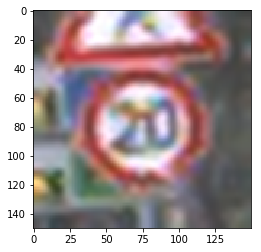

In [13]:
plt.imshow(x_train[0])

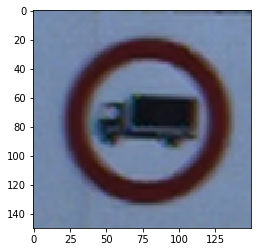

In [14]:
plt.imshow(x_test[0])

### Create Model

In [15]:
class CNN(object):
    
    def __init__(self, activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, filter_size, val_split):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.filter = filter_size
        self.val_split = val_split
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Conv2D(128, 
                             kernel_size =  self.filter, 
                             activation = self.activation,
                             padding = "same",
                             input_shape = self.input_shape,
                             kernel_regularizer = self.regularizer),
            tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
            tf.keras.layers.Conv2D(64,
                             kernel_size =  self.filter,
                             activation = self.activation,
                             input_shape = input_shape,   
                             padding = "same",
                             kernel_regularizer = self.regularizer),
            tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
            tf.keras.layers.Conv2D(32, 
                             kernel_size =  self.filter, 
                             activation = self.activation,
                             padding = "same",
                             input_shape = self.input_shape,
                             kernel_regularizer = self.regularizer),
            tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(len(set(self.y_train)), activation = tf.nn.softmax)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.01,
                                               patience = 2,
                                               verbose = 1)
        
        return early_stopping
  
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])
        
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 1,
                    callbacks = [self.callbacks()])
        
        return history, model

In [16]:
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 10
batch_size = 100
filter_size = (8, 8)
val_split = 0.2

x_test = x_test / np.max(x_train)
x_train = x_train / np.max(x_train)
x_train, y_train = shuffle(x_train, y_train)
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
model = CNN(activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, filter_size, val_split)
history, model = model.run_model()

Train on 31367 samples, validate on 7842 samples
Epoch 1/10
31367/31367 [==============================] - 132s 4ms/step - loss: 2.4295 - acc: 0.3054 - val_loss: 1.3328 - val_acc: 0.5397
Epoch 2/10
31367/31367 [==============================] - 126s 4ms/step - loss: 1.0016 - acc: 0.6711 - val_loss: 0.4505 - val_acc: 0.8559
Epoch 3/10
31367/31367 [==============================] - 125s 4ms/step - loss: 0.4181 - acc: 0.8665 - val_loss: 0.1959 - val_acc: 0.9457
Epoch 4/10
31367/31367 [==============================] - 125s 4ms/step - loss: 0.2210 - acc: 0.9301 - val_loss: 0.1452 - val_acc: 0.9550
Epoch 5/10
31367/31367 [==============================] - 125s 4ms/step - loss: 0.1470 - acc: 0.9532 - val_loss: 0.0927 - val_acc: 0.9746
Epoch 6/10
31367/31367 [==============================] - 124s 4ms/step - loss: 0.1106 - acc: 0.9651 - val_loss: 0.0772 - val_acc: 0.9788
Epoch 7/10
31367/31367 [==============================] - 125s 4ms/step - loss: 0.0874 - acc: 0.9734 - val_loss: 0.0600 - v

In [17]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk\n")

Saved model to disk



In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("\nTest accuracy: %.4f" % test_acc)

12630/12630 [==============================] - 24s 2ms/step

Test accuracy: 0.9286



Loss Evolution:


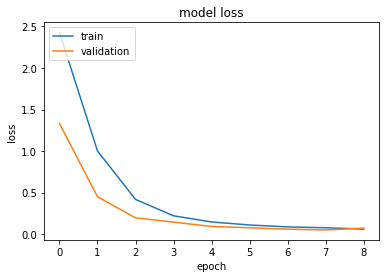

In [20]:
print("\nLoss Evolution:")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left') 
plt.show()

In [21]:
labels = {}
gtFile = open("signnames.csv") 
gtReader = csv.reader(gtFile, delimiter = ',')
next(gtReader, None)
for row in gtReader:
    if row[0] not in labels:
        labels[int(row[0])] = row[1]


Sample Test Cases:


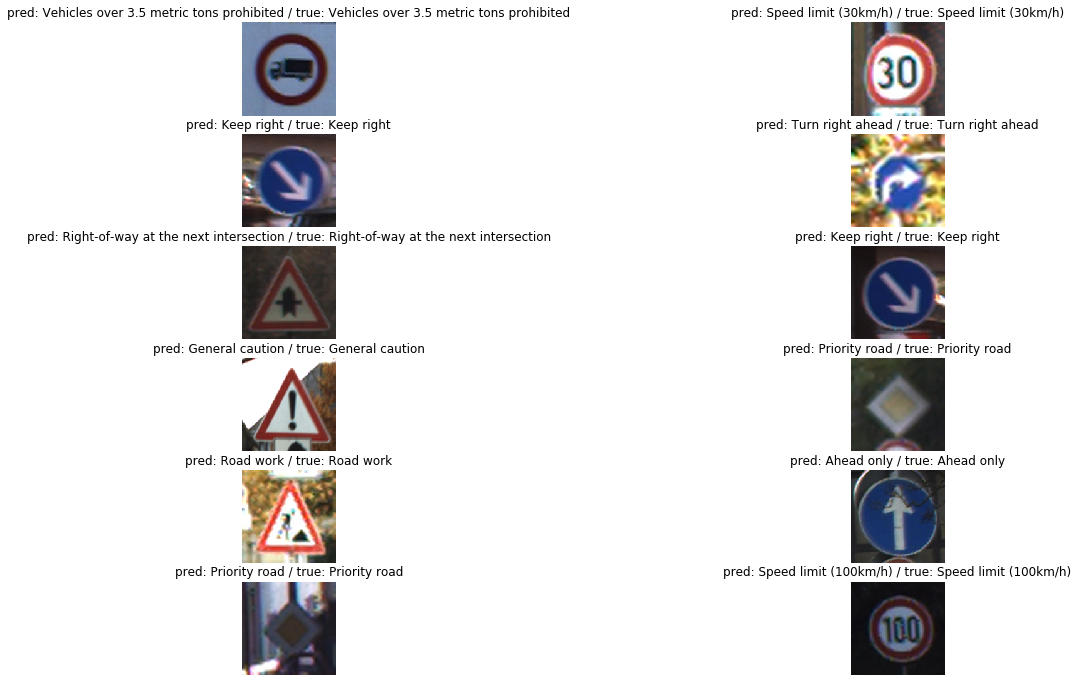

In [22]:
fig = plt.figure(figsize = (20, 12))

print("\nSample Test Cases:")
sample_x = x_test[:12]
sample_y = y_test[:12]
pred = model.predict(sample_x)
for i in range(len(sample_x)):
    fig.add_subplot(6, int(len(sample_x) / 6), i + 1)
    plt.axis('off')
    plt.imshow(sample_x[i][:,:,:])
    plt.title(str("pred: " + str(labels[np.argmax(pred[i])]) + " / true: " + str(labels[sample_y[i]])))

### Run Heatmaps

In [23]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")

loaded_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.train.AdamOptimizer())
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 128)     24704     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        524352    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        131104    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
__________

(150, 150, 3)
(150, 150, 3)


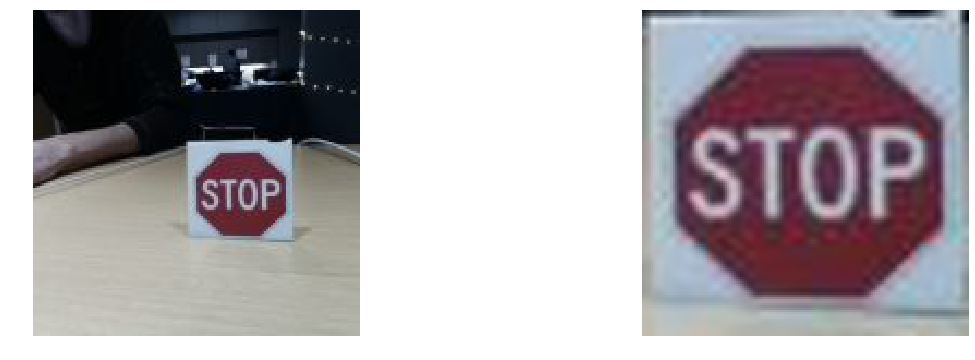

In [24]:
size = 150,150
path = "/home/pk2573/48216442_366282874163442_2157210378830872576_n.jpg"
img = np.array(Image.open(path))
img_1 = Image.fromarray(np.uint8(img))
img_1 = img_1.resize(size, Image.ANTIALIAS)
img_1 = np.array(img_1) / 255

img_2 = img[60:110:,70:120:,:]
img_2 = Image.fromarray(np.uint8(img_2))
img_2 = img_2.resize(size, Image.ANTIALIAS)
img_2 = np.array(img_2) / 255

images = [img_1, img_2]
fig = plt.figure(figsize = (20, 6))

for i in range(len(images)):
    fig.add_subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    print(images[i].shape)

In [25]:
for i in range(len(images)):
    im = np.expand_dims(images[i], axis = 0)
    pred = loaded_model.predict(im)
    print(labels[np.argmax(pred)], "with probability %.4f" %max(pred[0]))

Priority road with probability 0.3690
Stop with probability 0.9983


In [32]:
path = "/home/pk2573/48216442_366282874163442_2157210378830872576_n.jpg"
image, boxes = object_detection.detection(path, "yolov3.weights", "yolov3.cfg", "yolov3.txt")

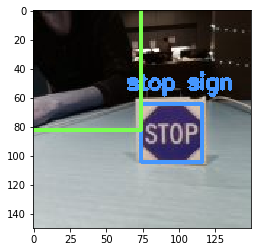

In [33]:
plt.imshow(image)

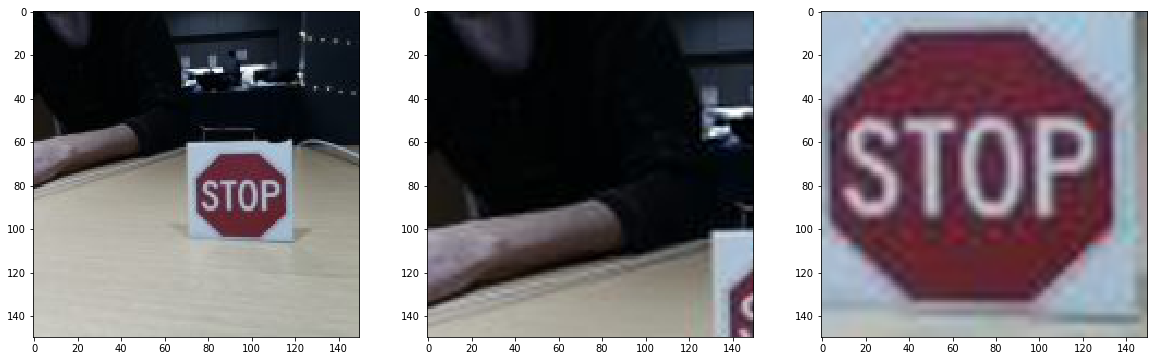

In [34]:
fig = plt.figure(figsize = (20, 6))
img = Image.open(path)
img = img.resize(size, Image.ANTIALIAS)
img = np.array(img)
fig.add_subplot(int(len(boxes) / 3) + 1, 3, 1)
plt.imshow(img)
images = [img / 255]
k = 2
for i in range(len(boxes)):
    x = int(max(boxes[i][0], 0))
    y = int(max(boxes[i][1], 0))
    w = int(max(boxes[i][2] + 5, 0))
    h = int(max(boxes[i][3] + 5, 0))
    temp = img[y:y + h,x:x + w]
    temp = Image.fromarray(np.uint8(temp))
    temp = temp.resize(size, Image.ANTIALIAS)
    fig.add_subplot(int(len(boxes) / 3) + 1, 3, k)
    plt.imshow(temp)
    images.append(np.array(temp) / 255)
    k += 1

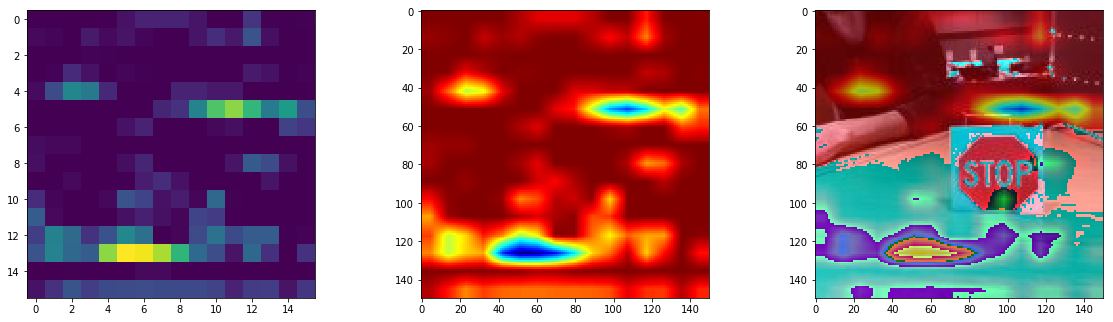

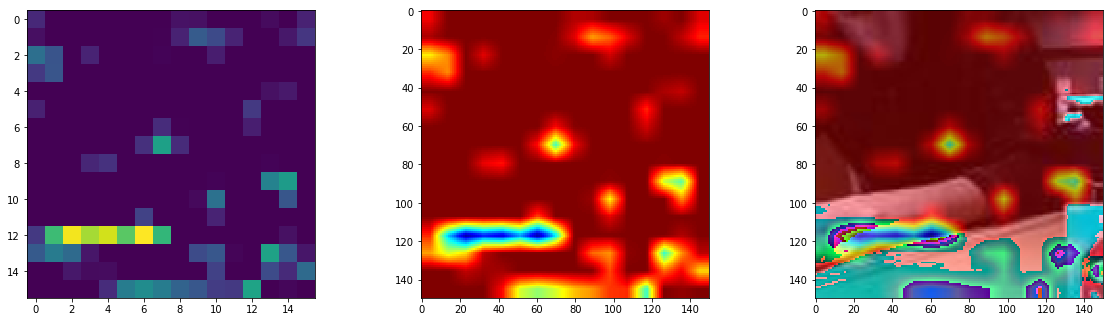

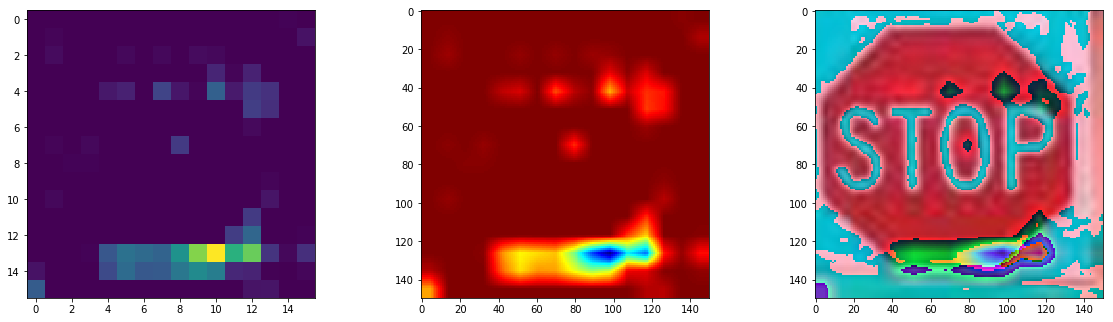

In [35]:
final_images = heatmap.heatmap(images, loaded_model)

In [36]:
preds = loaded_model.predict(np.array(images))

In [37]:
for i in range(len(preds)):
    print(labels[np.argmax(preds[i])], "with probability %.4f" %max(preds[i]))

Priority road with probability 0.3690
Go straight or left with probability 0.3950
Stop with probability 0.9702
